## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
from matplotlib.colors import ListedColormap
import folium
from folium.plugins import MarkerCluster
import leafmap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler

/tmp/ipykernel_43362/2700633454.py:5: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
/opt/conda/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. Fo

## Download data

In [2]:
aoi_dir = f'cuenca_arroyo_32614.gpkg'
resolutions = [11,10]

<Axes: >

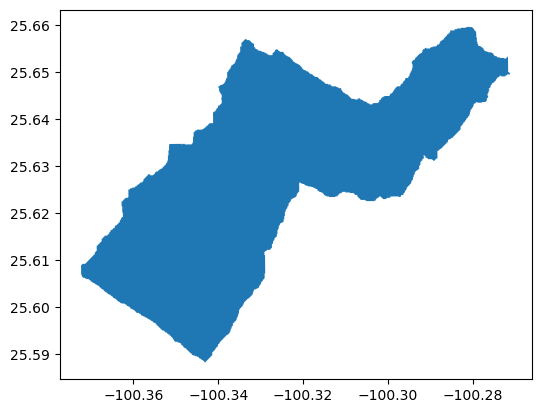

In [3]:
aoi = gpd.read_file(aoi_dir)
aoi = aoi.to_crs("EPSG:4326")

# Show
aoi.plot()

In [4]:
# Referencia
schema = 'projects_research'
table = 'arroyovivo_residuosjornada_point'
query = f"SELECT * FROM {schema}.{table}"
pois = aup.gdf_from_query(query, geometry_col='geometry')

# Show
print(pois.shape)
pois.head(1)

(13451, 11)


,id,itemname,tipo,material,quantity,latitude,longitude,altitude,datetime,jornada,geometry
0,2251010,Bolsa de plástico para comestibles,Productos Plásticos para Comida,plastico,5,25.641495,-100.293776,530.400024,2022-10-29 14:05:31+00:00,221029,MULTIPOINT (-100.29378 25.64149)


## Process data

### Process data - Create hexgrid and count by hex residuos and jornadas

In [5]:
# Create buffer for aoi in order to create a hexgrid that includes all the area
aoi_buffer = aoi.to_crs("EPSG:6372").buffer(60)
aoi_buffer = aoi_buffer.to_crs("EPSG:4326")
aoi_buffer = gpd.GeoDataFrame(geometry=aoi_buffer).dissolve()

# Go back to EPSG:4326
aoi = aoi.to_crs("EPSG:4326")

In [6]:
materiales_list = list(pois.material.unique())
jornadas_list = list(pois.jornada.unique())

pois_copy = pois.copy()
pois_copy.loc[:,'count'] = 1

i = 0

for res in resolutions:
    print(f"STARTING ANALYSIS FOR RES {res}")
    # Create hexgrid
    hexgrid = aup.create_hexgrid(aoi_buffer,res)
    
    # Duplicate hexgrid to merge later
    summary_tmp = hexgrid.copy()
    
    j = 1
    for material in materiales_list:
        print(f"Counting material {j} of {len(materiales_list)}: {material}")
        
        pois_process = pois_copy.loc[pois.material == material]
        pois_inhex = gpd.sjoin(pois_process, hexgrid)

        # Sum by hex count (individual points) and quantity (how much trash was registered in that point)
        groupby = pois_inhex.groupby(f'hex_id_{res}').agg({'count':np.sum,
                                                           'quantity':np.sum})
        groupby.rename(columns={'count':material,
                                'quantity':f'{material}_quantity'},inplace=True)
        groupby = groupby[[material,f'{material}_quantity']]

        # Join groupby with geometry
        summary_tmp = pd.merge(summary_tmp,groupby, on=f'hex_id_{res}',how='outer')
        
        j = j+1
        
    k = 1
    for jornada in jornadas_list:
        print(f"Counting jornada {k} of {len(jornadas_list)}: {jornada}")
        
        pois_process = pois_copy.loc[pois.jornada == jornada]
        pois_inhex = gpd.sjoin(pois_process, hexgrid)
        
        # Create tot column for this jornada (points and quantity)
        groupby = pois_inhex.groupby(f'hex_id_{res}').agg({'count':np.sum,
                                                           'quantity':np.sum})
        groupby.rename(columns={'count':f'{jornada}_points',
                                'quantity':f'{jornada}_quantity'},inplace=True)
        groupby = groupby[[f'{jornada}_points',f'{jornada}_quantity']]
        
        # Add this jornada to the jornadas_count column
        groupby[jornada] = 1
        
         # Join groupby with geometry
        summary_tmp = pd.merge(summary_tmp,groupby, on=f'hex_id_{res}',how='outer')
        
        k = k+1

    # Add resolution currently processed and change hex_id column name
    summary_tmp['res'] = res
    summary_tmp.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)
        
    if i == 0:
        summary = summary_tmp.copy()
    else:
        summary = pd.concat([summary,summary_tmp])
        
    i = i+1

# Show -----------------------------------------------
print(summary.shape)
summary.head(1)

STARTING ANALYSIS FOR RES 11
Counting material 1 of 23: plastico
Counting material 2 of 23: tabaco
Counting material 3 of 23: unicel/plastico
Counting material 4 of 23: metal
Counting material 5 of 23: vidrio
Counting material 6 of 23: llantas
Counting material 7 of 23: tela
Counting material 8 of 23: madera
Counting material 9 of 23: escombros
Counting material 10 of 23: papel
Counting material 11 of 23: carton
Counting material 12 of 23: otros
Counting material 13 of 23: unicel
Counting material 14 of 23: electronica
Counting material 15 of 23: organico
Counting material 16 of 23: vidrio/ceramica
Counting material 17 of 23: EPI
Counting material 18 of 23: salud e higiene
Counting material 19 of 23: plastico/tela
Counting material 20 of 23: pesca
Counting material 21 of 23: baterias
Counting material 22 of 23: goma
Counting material 23 of 23: cenizas
Counting jornada 1 of 21: 221029
Counting jornada 2 of 21: 220924
Counting jornada 3 of 21: 220705
Counting jornada 4 of 21: 220822
Coun

,hex_id,geometry,plastico,plastico_quantity,tabaco,tabaco_quantity,unicel/plastico,unicel/plastico_quantity,metal,metal_quantity,...,230311_points,230311_quantity,230311,230530_points,230530_quantity,230530,230419_points,230419_quantity,230419,res
0,8b48a215e258fff,"POLYGON ((-100.34498 25.60919, -100.34479 25.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


### Process data - Sum counted data (#Jornadas, total garbage points, total quantity and most_common residuo)

In [7]:
# Additional data -----------------------------------------------
# Remove NaNs
summary = summary.fillna(0)

# Count jornadas by hex and drop individual count columns
summary['jornadas_count'] = summary[jornadas_list].sum(axis=1)
summary.drop(columns=jornadas_list,inplace=True)
print("Counted jornadas")

# Sum total garbage points by hex and find most common residue by total data
summary['total_points'] = summary[materiales_list].sum(axis=1)
summary['most_common_point'] = summary[materiales_list].idxmax(axis=1)

# Sum total garbage quantity by hex and find most common residue by total quantity data
materiales_quantity_list = []
for material in materiales_list:
    column_name = f'{material}_quantity'
    materiales_quantity_list.append(column_name)
    
summary['total_quantity'] = summary[materiales_quantity_list].sum(axis=1)
summary['most_common_quantity'] = summary[materiales_quantity_list].idxmax(axis=1)

print("Found total points, quantity and most commmon residuo.")

# Delete hexs without data
idx = summary['total_points'] != 0
summary_f = summary.loc[idx]
#Sort values 
summary_f = summary_f.sort_values(by='total_points',ascending=False)

# Show -----------------------------------------------
print(summary_f.shape)
summary_f.head(1)

Counted jornadas
Found total points, quantity and most commmon residuo.
(560, 96)


,hex_id,geometry,plastico,plastico_quantity,tabaco,tabaco_quantity,unicel/plastico,unicel/plastico_quantity,metal,metal_quantity,...,230530_points,230530_quantity,230419_points,230419_quantity,res,jornadas_count,total_points,most_common_point,total_quantity,most_common_quantity
1417,8a48a20296a7fff,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",754.0,836.0,14.0,22.0,226.0,244.0,84.0,184.0,...,0.0,0.0,0.0,0.0,10,5.0,1583.0,plastico,1942.0,plastico_quantity


### Review output before proceeding to further analysis

In [8]:
# Review original vs processed total points and total quantity
print(f'Original total: {pois.shape[0]}')
print(f'total after groupby: {(summary_f.total_points.sum())/(len(resolutions))}')

print(f'Original total quantity: {pois.quantity.sum()}')
print(f'total quantity after groupby: {(summary_f.total_quantity.sum())/(len(resolutions))}')

Original total: 13451
total after groupby: 13451.0
Original total quantity: 21203
total quantity after groupby: 21203.0


In [9]:
# Verify: Points divided in each jornada column == total points?

# Create list of columns to review
jornadas_points_columns = []
for jornada in jornadas_list:
    column_name = f'{jornada}_points'
    jornadas_points_columns.append(column_name)
    
# Sum values on columns to review
prueba = summary_f.copy()
prueba['jornadas_points_checker'] = prueba[jornadas_points_columns].sum(axis=1)
prueba['diff'] = prueba['total_points'] - prueba['jornadas_points_checker']

# Print result
resultado = prueba['diff'].sum()
print(f'points_diff: {resultado}')

# ------------------------------------------------------------------------------
# Verify: Quantity divided in each jornada column == total quantity?

# Create list of columns to review
jornadas_quantity_columns = []
for jornada in jornadas_list:
    column_name = f'{jornada}_quantity'
    jornadas_quantity_columns.append(column_name)

# Sum values on columns to review
prueba = summary_f.copy()
prueba['jornadas_quantity_checker'] = prueba[jornadas_quantity_columns].sum(axis=1)
prueba['diff'] = prueba['total_quantity'] - prueba['jornadas_quantity_checker']

# Print result
resultado = prueba['diff'].sum()
print(f'quantity_diff: {resultado}')

points_diff: 0.0
quantity_diff: 0.0


### Process data - Add additional analysis data

In [10]:
# New analysis data
summary_f['totalpoints/jornadascount'] = summary_f['total_points'] / summary_f['jornadas_count']
summary_f['totalquantity/jornadascount'] = summary_f['total_quantity'] / summary_f['jornadas_count']
summary_f['log10(points/jornadas)'] = np.log10(summary_f['total_points'] / summary_f['jornadas_count'])
summary_f['log10(quantity/jornadas)'] = np.log10(summary_f['total_quantity'] / summary_f['jornadas_count'])

# Show
print(summary_f.shape)
summary_f.head(1)

(560, 100)


,hex_id,geometry,plastico,plastico_quantity,tabaco,tabaco_quantity,unicel/plastico,unicel/plastico_quantity,metal,metal_quantity,...,res,jornadas_count,total_points,most_common_point,total_quantity,most_common_quantity,totalpoints/jornadascount,totalquantity/jornadascount,log10(points/jornadas),log10(quantity/jornadas)
1417,8a48a20296a7fff,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",754.0,836.0,14.0,22.0,226.0,244.0,84.0,184.0,...,10,5.0,1583.0,plastico,1942.0,plastico_quantity,316.6,388.4,2.500511,2.589279


In [11]:
summary_f.columns

Index(['hex_id', 'geometry', 'plastico', 'plastico_quantity', 'tabaco',
       'tabaco_quantity', 'unicel/plastico', 'unicel/plastico_quantity',
       'metal', 'metal_quantity', 'vidrio', 'vidrio_quantity', 'llantas',
       'llantas_quantity', 'tela', 'tela_quantity', 'madera',
       'madera_quantity', 'escombros', 'escombros_quantity', 'papel',
       'papel_quantity', 'carton', 'carton_quantity', 'otros',
       'otros_quantity', 'unicel', 'unicel_quantity', 'electronica',
       'electronica_quantity', 'organico', 'organico_quantity',
       'vidrio/ceramica', 'vidrio/ceramica_quantity', 'EPI', 'EPI_quantity',
       'salud e higiene', 'salud e higiene_quantity', 'plastico/tela',
       'plastico/tela_quantity', 'pesca', 'pesca_quantity', 'baterias',
       'baterias_quantity', 'goma', 'goma_quantity', 'cenizas',
       'cenizas_quantity', '221029_points', '221029_quantity', '220924_points',
       '220924_quantity', '220705_points', '220705_quantity', '220822_points',
       '22

In [12]:
summary_f = summary_f [['hex_id', 'res', 
                        # Data by residuo
                        'plastico', 'plastico_quantity', 'tabaco',
                        'tabaco_quantity', 'unicel/plastico', 'unicel/plastico_quantity',
                        'metal', 'metal_quantity', 'vidrio', 'vidrio_quantity', 'llantas',
                        'llantas_quantity', 'tela', 'tela_quantity', 'madera',
                        'madera_quantity', 'escombros', 'escombros_quantity', 'papel',
                        'papel_quantity', 'carton', 'carton_quantity', 'otros',
                        'otros_quantity', 'unicel', 'unicel_quantity', 'electronica',
                        'electronica_quantity', 'organico', 'organico_quantity',
                        'vidrio/ceramica', 'vidrio/ceramica_quantity', 'EPI', 'EPI_quantity',
                        'salud e higiene', 'salud e higiene_quantity', 'plastico/tela',
                        'plastico/tela_quantity', 'pesca', 'pesca_quantity', 'baterias',
                        'baterias_quantity', 'goma', 'goma_quantity', 'cenizas',
                        'cenizas_quantity',
                        # Data by jornada
                        '221029_points', '221029_quantity', '220924_points',
                        '220924_quantity', '220705_points', '220705_quantity', '220822_points',
                        '220822_quantity', '220827_points', '220827_quantity', '220823_points',
                        '220823_quantity', '220824_points', '220824_quantity', '220829_points',
                        '220829_quantity', '220818_points', '220818_quantity', '221130_points',
                        '221130_quantity', '221201_points', '221201_quantity', '230415_points',
                        '230415_quantity', '230527_points', '230527_quantity', '230713_points',
                        '230713_quantity', '230819_points', '230819_quantity', '230817_points',
                        '230817_quantity', '230109_points', '230109_quantity', '230203_points',
                        '230203_quantity', '230311_points', '230311_quantity', '230530_points',
                        '230530_quantity', '230419_points', '230419_quantity',
                        # Summary data
                        'jornadas_count', 'total_points', 'most_common_point', 'total_quantity','most_common_quantity',
                        # Analysis data
                        'totalpoints/jornadascount','totalquantity/jornadascount','log10(points/jornadas)','log10(quantity/jornadas)',
                        # Geometry
                        'geometry']]

summary_f.head(1)

,hex_id,res,plastico,plastico_quantity,tabaco,tabaco_quantity,unicel/plastico,unicel/plastico_quantity,metal,metal_quantity,...,jornadas_count,total_points,most_common_point,total_quantity,most_common_quantity,totalpoints/jornadascount,totalquantity/jornadascount,log10(points/jornadas),log10(quantity/jornadas),geometry
1417,8a48a20296a7fff,10,754.0,836.0,14.0,22.0,226.0,244.0,84.0,184.0,...,5.0,1583.0,plastico,1942.0,plastico_quantity,316.6,388.4,2.500511,2.589279,"POLYGON ((-100.30269 25.63956, -100.30201 25.6..."


In [13]:
# Make all columns .lower()
columns = summary_f.columns
for column in columns:
    summary_f.rename(columns={column:column.lower()},inplace=True)

summary_f.head(1)

,hex_id,res,plastico,plastico_quantity,tabaco,tabaco_quantity,unicel/plastico,unicel/plastico_quantity,metal,metal_quantity,...,jornadas_count,total_points,most_common_point,total_quantity,most_common_quantity,totalpoints/jornadascount,totalquantity/jornadascount,log10(points/jornadas),log10(quantity/jornadas),geometry
1417,8a48a20296a7fff,10,754.0,836.0,14.0,22.0,226.0,244.0,84.0,184.0,...,5.0,1583.0,plastico,1942.0,plastico_quantity,316.6,388.4,2.500511,2.589279,"POLYGON ((-100.30269 25.63956, -100.30201 25.6..."


In [14]:
print(summary_f.shape)
summary_f.columns

(560, 100)


Index(['hex_id', 'res', 'plastico', 'plastico_quantity', 'tabaco',
       'tabaco_quantity', 'unicel/plastico', 'unicel/plastico_quantity',
       'metal', 'metal_quantity', 'vidrio', 'vidrio_quantity', 'llantas',
       'llantas_quantity', 'tela', 'tela_quantity', 'madera',
       'madera_quantity', 'escombros', 'escombros_quantity', 'papel',
       'papel_quantity', 'carton', 'carton_quantity', 'otros',
       'otros_quantity', 'unicel', 'unicel_quantity', 'electronica',
       'electronica_quantity', 'organico', 'organico_quantity',
       'vidrio/ceramica', 'vidrio/ceramica_quantity', 'epi', 'epi_quantity',
       'salud e higiene', 'salud e higiene_quantity', 'plastico/tela',
       'plastico/tela_quantity', 'pesca', 'pesca_quantity', 'baterias',
       'baterias_quantity', 'goma', 'goma_quantity', 'cenizas',
       'cenizas_quantity', '221029_points', '221029_quantity', '220924_points',
       '220924_quantity', '220705_points', '220705_quantity', '220822_points',
       '220822_

In [15]:
summary_f['Jornadas'] = summary_f['total_points'] / summary_f['totalpoints/jornadascount']
print(summary_f.shape)
summary_f.head(1)

(560, 101)


,hex_id,res,plastico,plastico_quantity,tabaco,tabaco_quantity,unicel/plastico,unicel/plastico_quantity,metal,metal_quantity,...,total_points,most_common_point,total_quantity,most_common_quantity,totalpoints/jornadascount,totalquantity/jornadascount,log10(points/jornadas),log10(quantity/jornadas),geometry,Jornadas
1417,8a48a20296a7fff,10,754.0,836.0,14.0,22.0,226.0,244.0,84.0,184.0,...,1583.0,plastico,1942.0,plastico_quantity,316.6,388.4,2.500511,2.589279,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",5.0


### Nuevo DataSet Para generar el merge

In [16]:
columnas = ['hex_id', 'res', 'geometry','Jornadas']

residuos = summary_f[columnas].copy()
print(residuos.shape)
residuos.head(1)

(560, 4)


,hex_id,res,geometry,Jornadas
1417,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",5.0


In [17]:
residuo_sorted = residuos.sort_index()
residuo_sorted.head()

,hex_id,res,geometry,Jornadas
5,8a48a202b30ffff,10,"POLYGON ((-100.29252 25.64584, -100.29184 25.6...",1.0
9,8a48a2029667fff,10,"POLYGON ((-100.30916 25.64025, -100.30848 25.6...",1.0
32,8a48a202ba1ffff,10,"POLYGON ((-100.29499 25.64119, -100.29431 25.6...",6.0
40,8b48a202b221fff,11,"POLYGON ((-100.29227 25.64777, -100.29209 25.6...",1.0
45,8b48a202b35dfff,11,"POLYGON ((-100.29455 25.64826, -100.29437 25.6...",1.0


In [18]:
schema = 'projects_research'
table = 'arroyovivo_residuos_hex'
query = f"SELECT * FROM {schema}.{table}"
resid = aup.gdf_from_query(query, geometry_col='geometry')

print(resid.shape)
resid.head(1)

(562, 51)


,hex_id,res,geometry,aluminio,aluminio_quantity,baterias,baterias_quantity,carton,carton_quantity,cenizas,...,unicel,unicel_quantity,vidrio,vidrio_quantity,epi,epi_quantity,total_points,most_common_point,total_quantity,most_common_quantity
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",13.0,24.0,0.0,0.0,36.0,44.0,0.0,...,207.0,259.0,89.0,137.0,1.0,1.0,1918.0,Plastico,2669.0,Plastico_quantity


### Merge

In [19]:
residuos = resid.merge(residuo_sorted, on=['hex_id','res','geometry'])

# Display the merged GeoDataFrame

print(residuos.shape)
residuos.head(2)

(557, 52)


,hex_id,res,geometry,aluminio,aluminio_quantity,baterias,baterias_quantity,carton,carton_quantity,cenizas,...,unicel_quantity,vidrio,vidrio_quantity,epi,epi_quantity,total_points,most_common_point,total_quantity,most_common_quantity,Jornadas
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",13.0,24.0,0.0,0.0,36.0,44.0,0.0,...,259.0,89.0,137.0,1.0,1.0,1918.0,Plastico,2669.0,Plastico_quantity,5.0
1,8a48a202978ffff,10,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",10.0,33.0,0.0,0.0,13.0,15.0,2.0,...,238.0,26.0,55.0,0.0,0.0,1122.0,Plastico,2473.0,Plastico_quantity,5.0


In [20]:
residuos.columns

Index(['hex_id', 'res', 'geometry', 'aluminio', 'aluminio_quantity',
       'baterias', 'baterias_quantity', 'carton', 'carton_quantity', 'cenizas',
       'cenizas_quantity', 'ceramica', 'ceramica_quantity', 'electronica',
       'electronica_quantity', 'escombros', 'escombros_quantity', 'goma',
       'goma_quantity', 'llantas', 'llantas_quantity', 'madera',
       'madera_quantity', 'metal', 'metal_quantity', 'organico',
       'organico_quantity', 'otros', 'otros_quantity', 'papel',
       'papel_quantity', 'pesca', 'pesca_quantity', 'plastico',
       'plastico_quantity', 'salud e higiene', 'salud e higiene_quantity',
       'tabaco', 'tabaco_quantity', 'tela', 'tela_quantity', 'unicel',
       'unicel_quantity', 'vidrio', 'vidrio_quantity', 'epi', 'epi_quantity',
       'total_points', 'most_common_point', 'total_quantity',
       'most_common_quantity', 'Jornadas'],
      dtype='object')

# GeoDataFrame con el promedio en cada columna por jornada

In [21]:
coldatos = ['aluminio', 'aluminio_quantity', 'baterias', 'baterias_quantity', 'carton', 'carton_quantity', 
                     'cenizas', 'cenizas_quantity', 'ceramica', 'ceramica_quantity', 'electronica', 
                     'electronica_quantity', 'escombros', 'escombros_quantity', 'goma', 'goma_quantity', 
                     'llantas', 'llantas_quantity', 'madera', 'madera_quantity', 'metal', 'metal_quantity', 
                     'organico', 'organico_quantity', 'otros', 'otros_quantity', 'papel', 'papel_quantity', 
                     'pesca', 'pesca_quantity', 'plastico', 'plastico_quantity', 'salud e higiene', 
                     'salud e higiene_quantity', 'tabaco', 'tabaco_quantity', 'tela', 'tela_quantity', 'unicel', 
                     'unicel_quantity', 'vidrio', 'vidrio_quantity', 'epi', 'epi_quantity']

# Divide each column by 'Jornadas'
for column in coldatos:
    residuos[column] = residuos[column] / residuos['Jornadas']

# Display the GeoDataFrame after the division
print(residuos.shape)
residuos.head(2)

(557, 52)


,hex_id,res,geometry,aluminio,aluminio_quantity,baterias,baterias_quantity,carton,carton_quantity,cenizas,...,unicel_quantity,vidrio,vidrio_quantity,epi,epi_quantity,total_points,most_common_point,total_quantity,most_common_quantity,Jornadas
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",2.6,4.8,0.0,0.0,7.2,8.8,0.0,...,51.8,17.8,27.4,0.2,0.2,1918.0,Plastico,2669.0,Plastico_quantity,5.0
1,8a48a202978ffff,10,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",2.0,6.6,0.0,0.0,2.6,3.0,0.4,...,47.6,5.2,11.0,0.0,0.0,1122.0,Plastico,2473.0,Plastico_quantity,5.0


## Estandarización

In [22]:
# Create a StandardScaler
scaler = StandardScaler()

# Standardize the selected columns
residuos[coldatos] = scaler.fit_transform(residuos[coldatos])
print(residuos.shape)
residuos.head()

(557, 52)


,hex_id,res,geometry,aluminio,aluminio_quantity,baterias,baterias_quantity,carton,carton_quantity,cenizas,...,unicel_quantity,vidrio,vidrio_quantity,epi,epi_quantity,total_points,most_common_point,total_quantity,most_common_quantity,Jornadas
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",4.953484,2.795958,-0.097076,-0.079399,5.169900,4.886608,-0.126484,...,9.528772,7.028760,4.785551,1.395316,0.899029,1918.0,Plastico,2669.0,Plastico_quantity,5.0
1,8a48a202978ffff,10,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",3.726319,3.922789,-0.097076,-0.079399,1.584256,1.381922,2.839893,...,8.725999,1.744476,1.725361,-0.159584,-0.150047,1122.0,Plastico,2473.0,Plastico_quantity,5.0
2,8a48a202baaffff,10,"POLYGON ((-100.29357 25.64128, -100.29289 25.6...",-0.364231,-0.208927,-0.097076,-0.079399,0.531947,3.496819,-0.126484,...,1.491481,-0.016952,0.092638,-0.159584,-0.150047,847.0,Plastico,2994.0,Plastico_quantity,4.0
3,8a48a202ba1ffff,10,"POLYGON ((-100.29499 25.64119, -100.29431 25.6...",0.658407,0.104082,-0.097076,-0.079399,-0.312498,-0.330138,-0.126484,...,0.488014,3.268251,1.321068,-0.159584,-0.150047,810.0,Plastico,1672.0,Plastico_quantity,6.0
4,8a48a202ba0ffff,10,"POLYGON ((-100.29641 25.64109, -100.29573 25.6...",-0.072049,-0.119496,-0.097076,-0.079399,-0.219702,-0.258202,-0.126484,...,0.310530,0.701998,0.712406,-0.159584,-0.150047,708.0,Plastico,1820.0,Plastico_quantity,7.0


### Verificar Estandarización

In [23]:
print("Media después de estandarización:")
print(residuos[coldatos].mean())

print("\nDesviación estándar después de estandarización:")
print(residuos[coldatos].std())

Media después de estandarización:
aluminio                    0.000000e+00
aluminio_quantity           0.000000e+00
baterias                    1.275660e-17
baterias_quantity           0.000000e+00
carton                      5.102641e-17
carton_quantity             5.102641e-17
cenizas                     1.913490e-17
cenizas_quantity            1.275660e-17
ceramica                    2.551320e-17
ceramica_quantity           1.275660e-17
electronica                -1.913490e-17
electronica_quantity        1.913490e-17
escombros                   5.102641e-17
escombros_quantity         -5.102641e-17
goma                        2.551320e-17
goma_quantity               2.551320e-17
llantas                     0.000000e+00
llantas_quantity           -2.551320e-17
madera                      5.102641e-17
madera_quantity            -3.826981e-17
metal                      -2.551320e-17
metal_quantity              1.020528e-16
organico                    5.102641e-17
organico_quantity      

# Dividir DataSet en Material y Quantity

## Material

In [24]:
col_material = ['hex_id', 'res','geometry', 'aluminio', 'baterias', 'carton','cenizas','ceramica','electronica','escombros',
                'goma','llantas','madera','metal','organico','otros','papel','pesca','plastico','salud e higiene',
                'tabaco','tela','unicel','vidrio','epi','total_points', 'most_common_point'] 
data_material = residuos[col_material].copy()
print(data_material.shape)

(557, 27)


### Res 11

In [25]:
data_material_11 = data_material[data_material['res'] == 11].copy()
print(data_material_11.shape)
data_material_11.head(2)

(416, 27)


,hex_id,res,geometry,aluminio,baterias,carton,cenizas,ceramica,electronica,escombros,...,pesca,plastico,salud e higiene,tabaco,tela,unicel,vidrio,epi,total_points,most_common_point
6,8b48a202baacfff,11,"POLYGON ((-100.29357 25.64128, -100.29339 25.6...",-0.364231,-0.097076,0.531947,-0.126484,-0.303301,-0.182867,5.010215,...,-0.095601,1.316813,0.047899,-0.45859,10.880229,-0.144011,-0.226646,-0.159584,656.0,Plastico
9,8b48a20296a6fff,11,"POLYGON ((-100.30220 25.63975, -100.30201 25.6...",1.271989,-0.097076,0.648870,-0.126484,0.013134,0.637456,-0.164994,...,-0.095601,1.690560,0.501567,-0.45859,1.501669,2.508680,2.163864,-0.159584,517.0,Plastico


#### PCA

In [26]:
colclustering = ['aluminio', 'baterias', 'carton', 'cenizas', 'ceramica', 'electronica',
       'escombros', 'goma', 'llantas', 'madera', 'metal', 'organico', 'otros',
       'papel', 'pesca', 'plastico', 'salud e higiene', 'tabaco', 'tela', 'unicel',
       'vidrio', 'epi']

pca = PCA(n_components=22).fit(data_material_11[colclustering])
new_df = pca.transform(data_material_11[colclustering])
var_exp = pca.explained_variance_ratio_

cumulative_var_exp = np.cumsum(var_exp)
# Find the index where cumulative sum exceeds 70%
components_needed = np.where(cumulative_var_exp >= 0.7)[0][0] + 1

for i in range(components_needed):
    data_material_11[f'PC_{i+1}'] = new_df[:, i]

print(f'Componentes principales necesarios para describir 70% de la varianza: {components_needed} ')

Componentes principales necesarios para describir 70% de la varianza: 9 


#### K-Value Óptimo

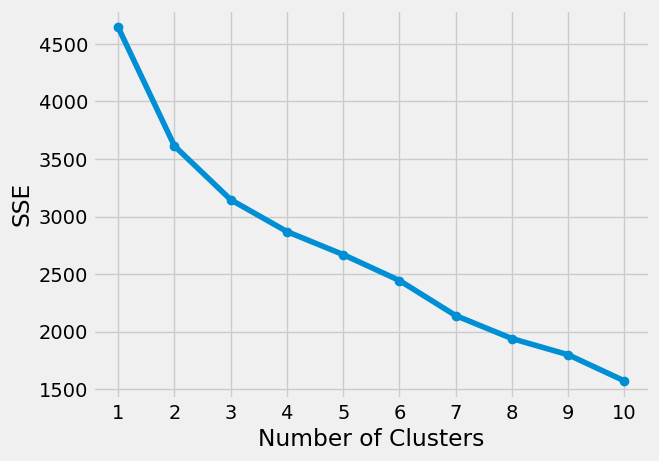

In [27]:
PCA_Material_11 = ['PC_1','PC_2','PC_3','PC_4','PC_5','PC_6','PC_7','PC_8','PC_9']
kmeans_kwargs = {
    "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
}

sse_11 = []

# Run K-means for each K and store the inertia value
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data_material_11[PCA_Material_11])
    sse_11.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse_11, marker='o')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [28]:
kl_11 = KneeLocator(
    range(1, 11), sse_11, curve="convex", direction="decreasing"
)
k_value_11 = kl_11.elbow
print(f'El valor óptimo de clusters basado en la data que tenemos es {k_value_11}')

El valor óptimo de clusters basado en la data que tenemos es 3


#### K-Means Clúster

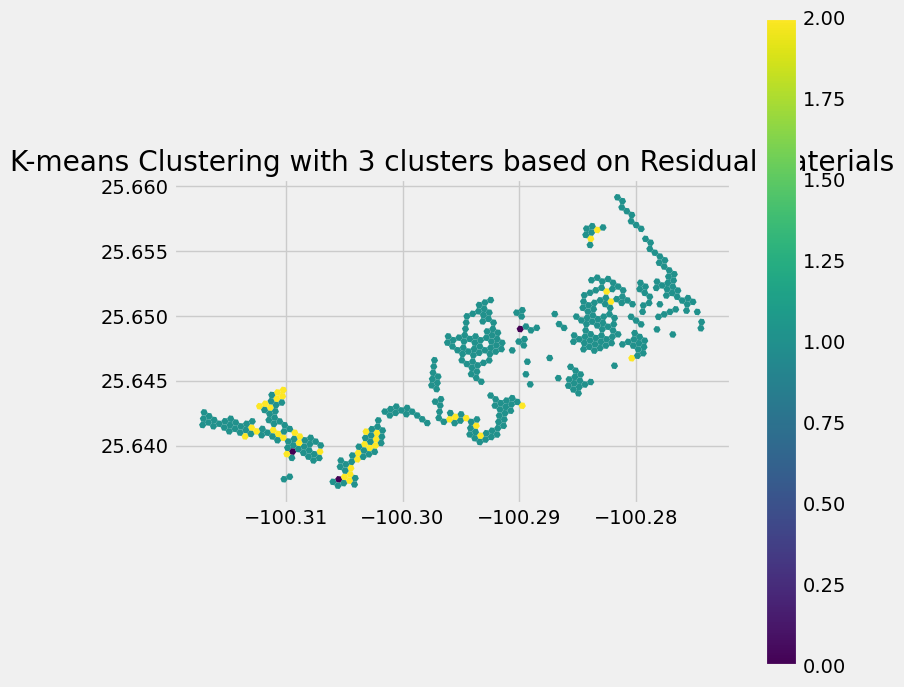

In [29]:
k_11 =  k_value_11


kmeans_11 = KMeans(n_clusters=k_11, **kmeans_kwargs)
data_material_11['cluster'] = kmeans_11.fit_predict(data_material_11[PCA_Material_11])

# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))
data_material_11.plot(column='cluster', cmap='viridis', legend=True, ax=ax)
plt.title(f'K-means Clustering with {k_11} clusters based on Residual Materials')
plt.show()

In [30]:
data_material_11['cluster'].unique()

array([2, 0, 1], dtype=int32)

In [31]:
data_material_11.head(1)

,hex_id,res,geometry,aluminio,baterias,carton,cenizas,ceramica,electronica,escombros,...,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,cluster
6,8b48a202baacfff,11,"POLYGON ((-100.29357 25.64128, -100.29339 25.6...",-0.364231,-0.097076,0.531947,-0.126484,-0.303301,-0.182867,5.010215,...,4.834521,-3.543875,-6.796097,-0.331726,2.810206,6.901841,4.123305,-2.750535,-1.447031,2


In [32]:
imp_var = ['aluminio', 'baterias', 'carton','cenizas','ceramica','electronica','escombros','goma',
           'llantas','madera','metal','organico','otros','papel','pesca','plastico','salud e higiene',
           'tabaco','tela','unicel','vidrio','epi'] 

#lista_hex = data_material['hex_id'].tolist()
lista_top3_maximos_11 = []
lista_top3_materiales_11 = []
cantidad_filas = data_material_11.shape[0]

for i in range(cantidad_filas):
    #hex_id = lista_hex[i]
    fila_seleccionada_11 = data_material_11.iloc[i, 3:-11]
    
    # Sort the residuals and get the top 3 values and corresponding materials
    sorted_residuos_11 = sorted(zip(fila_seleccionada_11, imp_var), reverse=True)
    top3_maximos_11 = sorted_residuos_11[:3]
    
    # Separate the top 3 values and materials into separate lists
    top3_maximos_valores_11, top3_maximos_materiales_11 = zip(*top3_maximos_11)
    
    lista_top3_maximos_11.append(top3_maximos_valores_11)
    lista_top3_materiales_11.append(top3_maximos_materiales_11)
    
    # Print the results if needed
    #print(f'Top 3 residuals of hexagon {hex_id} ({i}): {top3_maximos}')

# Add the lists to the DataFrame
data_material_11['top3_maximos'] = lista_top3_maximos_11
data_material_11['top3_materiales'] = lista_top3_materiales_11
print(data_material_11.shape)
data_material_11.head()

(416, 39)


,hex_id,res,geometry,aluminio,baterias,carton,cenizas,ceramica,electronica,escombros,...,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,cluster,top3_maximos,top3_materiales
6,8b48a202baacfff,11,"POLYGON ((-100.29357 25.64128, -100.29339 25.6...",-0.364231,-0.097076,0.531947,-0.126484,-0.303301,-0.182867,5.010215,...,-6.796097,-0.331726,2.810206,6.901841,4.123305,-2.750535,-1.447031,2,"(10.880229391240443, 7.301449277587963, 5.0102...","(tela, papel, escombros)"
9,8b48a20296a6fff,11,"POLYGON ((-100.30220 25.63975, -100.30201 25.6...",1.271989,-0.097076,0.648870,-0.126484,0.013134,0.637456,-0.164994,...,-0.311464,-0.822211,0.402508,-0.051320,-0.831911,-0.473546,-0.304690,2,"(2.508680134458372, 2.1638635643583326, 1.9500...","(unicel, vidrio, metal)"
10,8b48a202ba0afff,11,"POLYGON ((-100.29585 25.64177, -100.29567 25.6...",-0.364231,-0.097076,-0.182584,-0.126484,-0.303301,-0.182867,3.976529,...,-2.320221,-0.621898,0.970391,1.687032,3.085037,0.677660,0.728454,2,"(3.976528843540098, 2.4574660235819867, 1.8780...","(escombros, pesca, tela)"
11,8b48a202baa5fff,11,"POLYGON ((-100.29320 25.64050, -100.29302 25.6...",-0.364231,-0.097076,-0.442413,-0.126484,0.092243,-0.182867,10.093917,...,-3.409295,0.219156,1.459526,4.906697,2.946236,-0.351762,1.054764,2,"(10.093917498848928, 1.322051868171657, 1.1469...","(escombros, tela, plastico)"
13,8b48a20296a5fff,11,"POLYGON ((-100.30312 25.63985, -100.30294 25.6...",3.726319,-0.097076,2.675539,-0.126484,0.487786,-0.182867,0.282372,...,-2.567915,1.868934,-2.276883,-2.369566,-1.357240,-0.235935,0.521747,2,"(5.41292584914312, 4.417495199378891, 3.727666...","(plastico, unicel, epi)"


### Res 10

In [33]:
data_material_10 = data_material[data_material['res'] == 10].copy()
print(data_material_10.shape)
data_material_10.head(2)

(141, 27)


,hex_id,res,geometry,aluminio,baterias,carton,cenizas,ceramica,electronica,escombros,...,pesca,plastico,salud e higiene,tabaco,tela,unicel,vidrio,epi,total_points,most_common_point
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",4.953484,-0.097076,5.169900,-0.126484,2.861046,0.637456,0.526389,...,-0.095601,8.523707,4.856773,1.968048,3.964984,11.266773,7.028760,1.395316,1918.0,Plastico
1,8a48a202978ffff,10,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",3.726319,-0.097076,1.584256,2.839893,0.329569,1.457779,0.689068,...,-0.095601,5.186413,1.771835,0.848061,3.811027,2.845530,1.744476,-0.159584,1122.0,Plastico


#### PCA

In [34]:
pca = PCA(n_components=22).fit(data_material_10[colclustering])
new_df = pca.transform(data_material_10[colclustering])
var_exp = pca.explained_variance_ratio_

cumulative_var_exp = np.cumsum(var_exp)
# Find the index where cumulative sum exceeds 70%
components_needed = np.where(cumulative_var_exp >= 0.7)[0][0] + 1

for i in range(components_needed):
    data_material_10[f'PC_{i+1}'] = new_df[:, i]

print(f'Componentes principales necesarios para describir 70% de la varianza: {components_needed} ')

Componentes principales necesarios para describir 70% de la varianza: 7 


In [35]:
data_material_10.head(2)

,hex_id,res,geometry,aluminio,baterias,carton,cenizas,ceramica,electronica,escombros,...,epi,total_points,most_common_point,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",4.953484,-0.097076,5.169900,-0.126484,2.861046,0.637456,0.526389,...,1.395316,1918.0,Plastico,16.113301,4.780216,3.981377,-3.032277,-2.615548,-4.388044,0.041117
1,8a48a202978ffff,10,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",3.726319,-0.097076,1.584256,2.839893,0.329569,1.457779,0.689068,...,-0.159584,1122.0,Plastico,8.693757,0.842856,0.194694,2.010147,-1.313992,-0.349033,1.628833


#### K-Value Óptimo

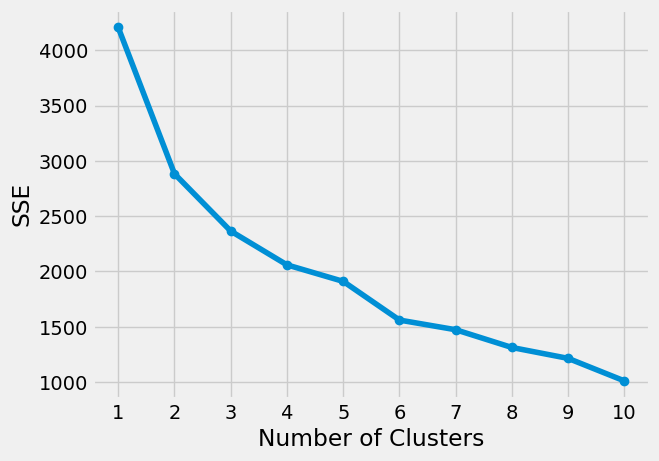

In [36]:
PCA_Material_10 = ['PC_1','PC_2','PC_3','PC_4','PC_5','PC_6','PC_7']
kmeans_kwargs = {
    "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
}

sse_10 = []

# Run K-means for each K and store the inertia value
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data_material_10[PCA_Material_10])
    sse_10.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse_10, marker='o')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [37]:
kl_10 = KneeLocator(
    range(1, 11), sse_10, curve="convex", direction="decreasing"
)
k_value_10 = kl_10.elbow
print(f'El valor óptimo de clusters basado en la data que tenemos es {k_value_10}')

El valor óptimo de clusters basado en la data que tenemos es 3


#### K-Means Clúster

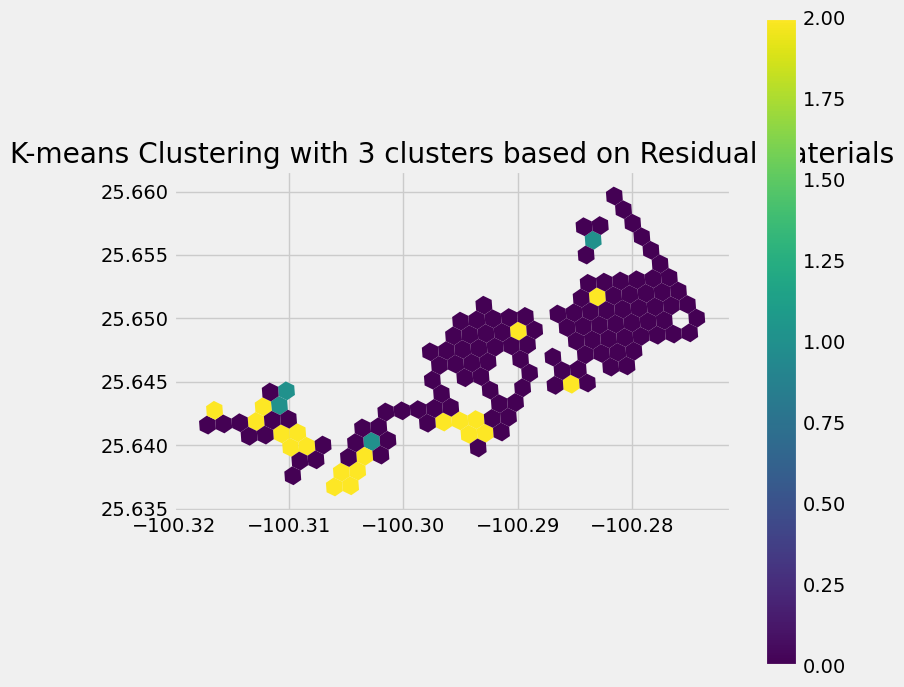

In [38]:
k_10 =  k_value_10


kmeans_10 = KMeans(n_clusters=k_10, **kmeans_kwargs)
data_material_10['cluster'] = kmeans_10.fit_predict(data_material_10[PCA_Material_10])

# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))
data_material_10.plot(column='cluster', cmap='viridis', legend=True, ax=ax)
plt.title(f'K-means Clustering with {k_10} clusters based on Residual Materials')
plt.show()

In [39]:
data_material_10['cluster'].unique()

array([1, 2, 0], dtype=int32)

In [40]:
data_material_10.head(1)

,hex_id,res,geometry,aluminio,baterias,carton,cenizas,ceramica,electronica,escombros,...,total_points,most_common_point,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,cluster
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",4.953484,-0.097076,5.1699,-0.126484,2.861046,0.637456,0.526389,...,1918.0,Plastico,16.113301,4.780216,3.981377,-3.032277,-2.615548,-4.388044,0.041117,1


#### 3 Materiales Más importantes por Hexágono

In [41]:
imp_var = ['aluminio', 'baterias', 'carton','cenizas','ceramica','electronica','escombros','goma',
           'llantas','madera','metal','organico','otros','papel','pesca','plastico','salud e higiene',
           'tabaco','tela','unicel','vidrio','epi'] 

#lista_hex = data_material['hex_id'].tolist()
lista_top3_maximos_10 = []
lista_top3_materiales_10 = []
cantidad_filas = data_material_10.shape[0]

for i in range(cantidad_filas):
    #hex_id = lista_hex[i]
    fila_seleccionada_10 = data_material_10.iloc[i, 3:-10]
    
    # Sort the residuals and get the top 3 values and corresponding materials
    sorted_residuos_10 = sorted(zip(fila_seleccionada_10, imp_var), reverse=True)
    top3_maximos_10 = sorted_residuos_10[:3]
    
    # Separate the top 3 values and materials into separate lists
    top3_maximos_valores_10, top3_maximos_materiales_10 = zip(*top3_maximos_10)
    
    lista_top3_maximos_10.append(top3_maximos_valores_10)
    lista_top3_materiales_10.append(top3_maximos_materiales_10)
    
    # Print the results if needed
    #print(f'Top 3 residuals of hexagon {hex_id} ({i}): {top3_maximos}')

# Add the lists to the DataFrame
data_material_10['top3_maximos'] = lista_top3_maximos_10
data_material_10['top3_materiales'] = lista_top3_materiales_10
print(data_material_10.shape)
data_material_10.head()

(141, 37)


,hex_id,res,geometry,aluminio,baterias,carton,cenizas,ceramica,electronica,escombros,...,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,cluster,top3_maximos,top3_materiales
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",4.953484,-0.097076,5.169900,-0.126484,2.861046,0.637456,0.526389,...,16.113301,4.780216,3.981377,-3.032277,-2.615548,-4.388044,0.041117,1,"(11.266772785270167, 8.523706638633007, 7.0287...","(unicel, plastico, vidrio)"
1,8a48a202978ffff,10,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",3.726319,-0.097076,1.584256,2.839893,0.329569,1.457779,0.689068,...,8.693757,0.842856,0.194694,2.010147,-1.313992,-0.349033,1.628833,2,"(5.25174984205531, 5.186412684859875, 4.166772...","(llantas, plastico, otros)"
2,8a48a202baaffff,10,"POLYGON ((-100.29357 25.64128, -100.29289 25.6...",-0.364231,-0.097076,0.531947,-0.126484,-0.303301,-0.182867,7.602903,...,4.758026,-1.956029,9.485166,4.734099,-2.078338,7.567402,-3.939595,2,"(10.751931706367037, 7.878523698216183, 7.6029...","(tela, papel, escombros)"
3,8a48a202ba1ffff,10,"POLYGON ((-100.29499 25.64119, -100.29431 25.6...",0.658407,-0.097076,-0.312498,-0.126484,0.224090,-0.182867,5.433857,...,2.753948,-0.584537,3.190986,2.193848,0.850459,2.018687,-1.750855,2,"(5.433856888849125, 4.223719034237456, 3.26825...","(escombros, papel, vidrio)"
4,8a48a202ba0ffff,10,"POLYGON ((-100.29641 25.64109, -100.29573 25.6...",-0.072049,-0.097076,-0.219702,-0.126484,-0.077276,-0.182867,4.175035,...,0.807303,-0.563087,2.291771,2.973378,-0.914420,1.832453,-1.207547,2,"(4.175035321472556, 2.092742182618713, 2.07350...","(escombros, pesca, tela)"


## Quantity

In [42]:
col_qty = ['hex_id', 'res', 'geometry', 'aluminio_quantity', 'baterias_quantity', 'carton_quantity','cenizas_quantity',
                  'ceramica_quantity','electronica_quantity','escombros_quantity','goma_quantity','llantas_quantity', 
                  'madera_quantity','metal_quantity','organico_quantity','otros_quantity','papel_quantity','pesca_quantity',
                  'plastico_quantity','salud e higiene_quantity','tabaco_quantity','tela_quantity','unicel_quantity',
                  'vidrio_quantity','epi_quantity','total_quantity','most_common_quantity'] 
data_quantity = residuos[col_qty].copy()
print(data_quantity.shape)

(557, 27)


### Res 11

In [43]:
data_quantity_11 = data_quantity[data_quantity['res'] == 11].copy()
print(data_quantity_11.shape)
data_quantity_11.head(2)

(416, 27)


,hex_id,res,geometry,aluminio_quantity,baterias_quantity,carton_quantity,cenizas_quantity,ceramica_quantity,electronica_quantity,escombros_quantity,...,pesca_quantity,plastico_quantity,salud e higiene_quantity,tabaco_quantity,tela_quantity,unicel_quantity,vidrio_quantity,epi_quantity,total_quantity,most_common_quantity
6,8b48a202baacfff,11,"POLYGON ((-100.29357 25.64128, -100.29339 25.6...",-0.208927,-0.079399,3.496819,-0.1045,-0.181031,-0.188879,2.997889,...,-0.080339,4.662126,-0.082687,-0.341508,11.695076,1.491481,-0.233907,-0.150047,2179.0,Plastico_quantity
9,8b48a20296a6fff,11,"POLYGON ((-100.30220 25.63975, -100.30201 25.6...",1.418719,-0.079399,1.381922,-0.1045,0.173900,1.291156,-0.031746,...,-0.080339,0.793869,0.247115,-0.341508,0.687003,2.303811,0.941654,-0.150047,734.0,Plastico_quantity


#### PCA

In [44]:
colclust = ['aluminio_quantity', 'baterias_quantity',
       'carton_quantity', 'cenizas_quantity', 'ceramica_quantity',
       'electronica_quantity', 'escombros_quantity', 'goma_quantity',
       'llantas_quantity', 'madera_quantity', 'metal_quantity',
       'organico_quantity', 'otros_quantity', 'papel_quantity',
       'pesca_quantity', 'plastico_quantity', 'salud e higiene_quantity',
       'tabaco_quantity', 'tela_quantity', 'unicel_quantity',
       'vidrio_quantity', 'epi_quantity']

pca = PCA(n_components=22).fit(data_quantity_11[colclust])
new_df = pca.transform(data_quantity_11[colclust])
var_exp = pca.explained_variance_ratio_

cumulative_var_exp = np.cumsum(var_exp)
# Find the index where cumulative sum exceeds 70%
components_needed = np.where(cumulative_var_exp >= 0.7)[0][0] + 1

for i in range(components_needed):
    data_quantity_11[f'PC_{i+1}'] = new_df[:, i]

print(f'Componentes principales necesarios para describir 70% de la varianza: {components_needed} ')

Componentes principales necesarios para describir 70% de la varianza: 9 


In [45]:
data_quantity_11.head(2)

,hex_id,res,geometry,aluminio_quantity,baterias_quantity,carton_quantity,cenizas_quantity,ceramica_quantity,electronica_quantity,escombros_quantity,...,most_common_quantity,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9
6,8b48a202baacfff,11,"POLYGON ((-100.29357 25.64128, -100.29339 25.6...",-0.208927,-0.079399,3.496819,-0.1045,-0.181031,-0.188879,2.997889,...,Plastico_quantity,7.340152,-3.095555,-0.136906,-5.700838,-2.373283,-0.105370,-2.561285,6.162365,5.624867
9,8b48a20296a6fff,11,"POLYGON ((-100.30220 25.63975, -100.30201 25.6...",1.418719,-0.079399,1.381922,-0.1045,0.173900,1.291156,-0.031746,...,Plastico_quantity,3.283600,-0.636431,-0.090851,-0.996807,-0.021744,-0.524548,-0.321753,-0.096117,0.258726


#### K-Value Óptimo

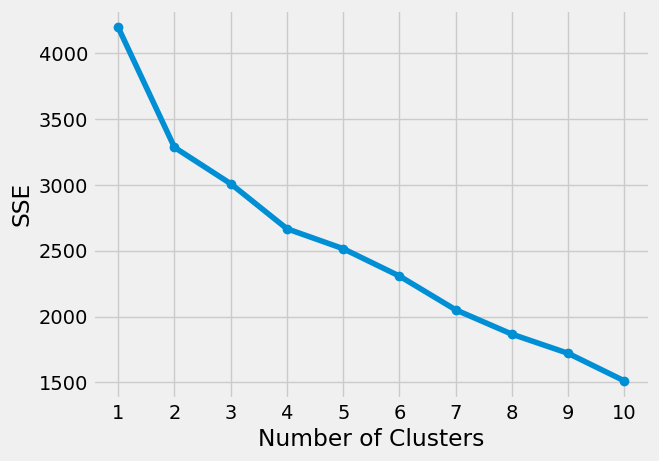

In [46]:
PCA_Quantity_11 = ['PC_1','PC_2','PC_3','PC_4','PC_5','PC_6','PC_7','PC_8','PC_9']

kmeans_kwargs = {
    "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
}

SSE_11 = []

# Run K-means for each K and store the inertia value
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data_quantity_11[PCA_Quantity_11])
    SSE_11.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), SSE_11, marker='o')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [47]:
Kl_11 = KneeLocator(
    range(1, 11), SSE_11, curve="convex", direction="decreasing"
)
K_value_11 = Kl_11.elbow
print(f'El valor óptimo de clusters basado en la data que tenemos es {K_value_11}')

El valor óptimo de clusters basado en la data que tenemos es 4


#### K-Means Clúster

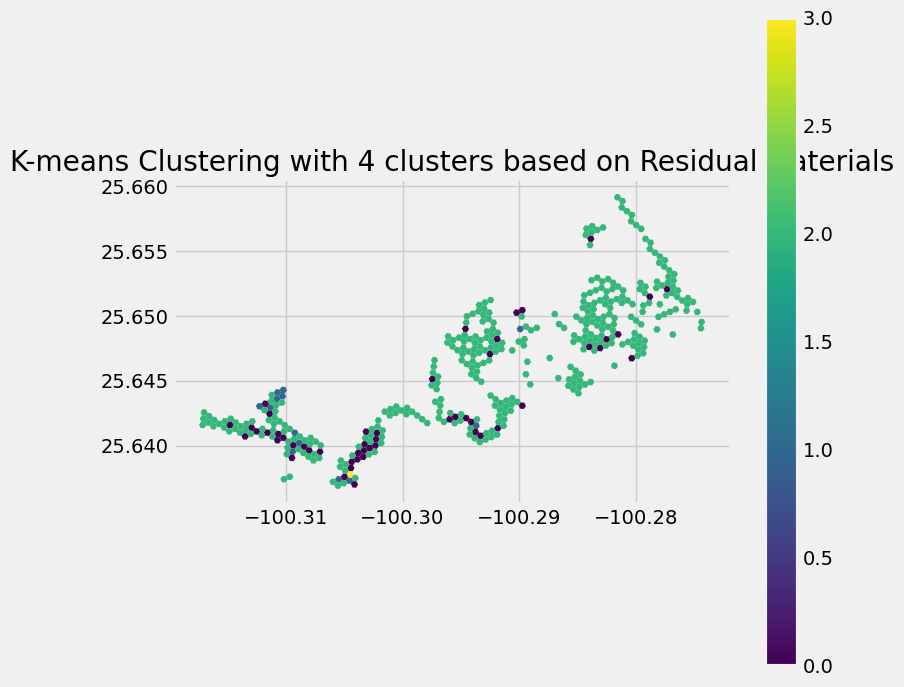

In [48]:
K_11 =  K_value_11


Kmeans_11 = KMeans(n_clusters=K_11, **kmeans_kwargs)
data_quantity_11['cluster'] = Kmeans_11.fit_predict(data_quantity_11[PCA_Quantity_11])

# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))
data_quantity_11.plot(column='cluster', cmap='viridis', legend=True, ax=ax)
plt.title(f'K-means Clustering with {K_11} clusters based on Residual Materials')
plt.show()

In [49]:
data_quantity_11['cluster'].unique()

array([1, 0, 2, 3], dtype=int32)

In [50]:
data_quantity_11.head(1)

,hex_id,res,geometry,aluminio_quantity,baterias_quantity,carton_quantity,cenizas_quantity,ceramica_quantity,electronica_quantity,escombros_quantity,...,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,cluster
6,8b48a202baacfff,11,"POLYGON ((-100.29357 25.64128, -100.29339 25.6...",-0.208927,-0.079399,3.496819,-0.1045,-0.181031,-0.188879,2.997889,...,7.340152,-3.095555,-0.136906,-5.700838,-2.373283,-0.10537,-2.561285,6.162365,5.624867,1


#### 3 materiales más importantes por hexágono

In [51]:
imp_var = ['aluminio_quantity', 'baterias_quantity',
       'carton_quantity', 'cenizas_quantity', 'ceramica_quantity',
       'electronica_quantity', 'escombros_quantity', 'goma_quantity',
       'llantas_quantity', 'madera_quantity', 'metal_quantity',
       'organico_quantity', 'otros_quantity', 'papel_quantity',
       'pesca_quantity', 'plastico_quantity', 'salud e higiene_quantity',
       'tabaco_quantity', 'tela_quantity', 'unicel_quantity',
       'vidrio_quantity', 'epi_quantity']

#lista_hex = data_quantity['hex_id'].tolist()
lista_top3_maximos_11 = []
lista_top3_materiales_11 = []
cantidad_filas = data_quantity_11.shape[0]

for i in range(cantidad_filas):
    #hex_id = lista_hex[i]
    fila_seleccionada_11 = data_quantity_11.iloc[i, 3:-12]
    
    # Sort the residuals and get the top 3 values and corresponding materials
    sorted_residuos_11 = sorted(zip(fila_seleccionada_11, imp_var), reverse=True)
    top3_maximos_11 = sorted_residuos_11[:3]
    
    # Separate the top 3 values and materials into separate lists
    top3_maximos_valores_11, top3_maximos_materiales_11 = zip(*top3_maximos_11)
    
    lista_top3_maximos_11.append(top3_maximos_valores_11)
    lista_top3_materiales_11.append(top3_maximos_materiales_11)
    
    # Print the results if needed
    #print(f'Top 3 residuals of hexagon {hex_id} ({i}): {top3_maximos}')

# Add the lists to the DataFrame
data_quantity_11['top3_maximos'] = lista_top3_maximos_11
data_quantity_11['top3_materiales'] = lista_top3_materiales_11
print(data_quantity_11.shape)
data_quantity_11.head()

(416, 39)


,hex_id,res,geometry,aluminio_quantity,baterias_quantity,carton_quantity,cenizas_quantity,ceramica_quantity,electronica_quantity,escombros_quantity,...,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,cluster,top3_maximos,top3_materiales
6,8b48a202baacfff,11,"POLYGON ((-100.29357 25.64128, -100.29339 25.6...",-0.208927,-0.079399,3.496819,-0.1045,-0.181031,-0.188879,2.997889,...,-0.136906,-5.700838,-2.373283,-0.105370,-2.561285,6.162365,5.624867,1,"(11.695075874506838, 5.409879109271044, 4.6621...","(tela_quantity, papel_quantity, plastico_quant..."
9,8b48a20296a6fff,11,"POLYGON ((-100.30220 25.63975, -100.30201 25.6...",1.418719,-0.079399,1.381922,-0.1045,0.173900,1.291156,-0.031746,...,-0.090851,-0.996807,-0.021744,-0.524548,-0.321753,-0.096117,0.258726,0,"(2.3038112155101205, 1.7814974749696981, 1.418...","(unicel_quantity, papel_quantity, aluminio_qua..."
10,8b48a202ba0afff,11,"POLYGON ((-100.29585 25.64177, -100.29567 25.6...",-0.208927,-0.079399,-0.229428,-0.1045,-0.181031,-0.188879,2.669731,...,0.071570,-1.328247,0.382424,0.518248,0.348108,1.095513,0.676492,0,"(2.669731363747249, 2.265077053383663, 1.28158...","(escombros_quantity, plastico_quantity, pesca_..."
11,8b48a202baa5fff,11,"POLYGON ((-100.29320 25.64050, -100.29302 25.6...",-0.208927,-0.079399,-0.430847,-0.1045,-0.070115,-0.188879,6.459421,...,0.713982,-1.894324,-0.103861,0.287494,0.118238,0.710607,-0.120812,0,"(6.4594210781424755, 1.4921150330420765, 1.253...","(escombros_quantity, vidrio_quantity, organico..."
13,8b48a20296a5fff,11,"POLYGON ((-100.30312 25.63985, -100.30294 25.6...",1.043108,-0.079399,1.986178,-0.1045,0.040801,-0.188879,0.044471,...,-0.352536,-0.026609,-2.104790,1.097621,0.864687,-0.395185,0.260712,0,"(2.877220802193855, 2.4726434744884664, 2.1315...","(unicel_quantity, epi_quantity, plastico_quant..."


### Res 10

In [52]:
data_quantity_10 = data_quantity[data_quantity['res'] == 10].copy()
print(data_quantity_10.shape)
data_quantity_10.head(2)

(141, 27)


,hex_id,res,geometry,aluminio_quantity,baterias_quantity,carton_quantity,cenizas_quantity,ceramica_quantity,electronica_quantity,escombros_quantity,...,pesca_quantity,plastico_quantity,salud e higiene_quantity,tabaco_quantity,tela_quantity,unicel_quantity,vidrio_quantity,epi_quantity,total_quantity,most_common_quantity
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",2.795958,-0.079399,4.886608,-0.104500,4.433064,1.291156,0.654209,...,-0.080339,4.384946,3.168216,1.367725,1.579436,9.528772,4.785551,0.899029,2669.0,Plastico_quantity
1,8a48a202978ffff,10,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",3.922789,-0.079399,1.381922,1.620132,0.262632,3.511210,1.162324,...,-0.080339,4.911507,3.262445,0.228236,2.623414,8.725999,1.725361,-0.150047,2473.0,Plastico_quantity


#### PCA

In [53]:
colclust = ['aluminio_quantity', 'baterias_quantity',
       'carton_quantity', 'cenizas_quantity', 'ceramica_quantity',
       'electronica_quantity', 'escombros_quantity', 'goma_quantity',
       'llantas_quantity', 'madera_quantity', 'metal_quantity',
       'organico_quantity', 'otros_quantity', 'papel_quantity',
       'pesca_quantity', 'plastico_quantity', 'salud e higiene_quantity',
       'tabaco_quantity', 'tela_quantity', 'unicel_quantity',
       'vidrio_quantity', 'epi_quantity']

pca = PCA(n_components=22).fit(data_quantity_10[colclust])
new_df = pca.transform(data_quantity_10[colclust])
var_exp = pca.explained_variance_ratio_

cumulative_var_exp = np.cumsum(var_exp)
# Find the index where cumulative sum exceeds 70%
components_needed = np.where(cumulative_var_exp >= 0.7)[0][0] + 1

for i in range(components_needed):
    data_quantity_10[f'PC_{i+1}'] = new_df[:, i]

print(f'Componentes principales necesarios para describir 70% de la varianza: {components_needed} ')

Componentes principales necesarios para describir 70% de la varianza: 6 


In [54]:
data_quantity_10.head(2)

,hex_id,res,geometry,aluminio_quantity,baterias_quantity,carton_quantity,cenizas_quantity,ceramica_quantity,electronica_quantity,escombros_quantity,...,vidrio_quantity,epi_quantity,total_quantity,most_common_quantity,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",2.795958,-0.079399,4.886608,-0.104500,4.433064,1.291156,0.654209,...,4.785551,0.899029,2669.0,Plastico_quantity,11.514092,-4.262148,-0.300548,2.866509,-2.974002,-0.507405
1,8a48a202978ffff,10,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",3.922789,-0.079399,1.381922,1.620132,0.262632,3.511210,1.162324,...,1.725361,-0.150047,2473.0,Plastico_quantity,9.070882,-1.336028,2.954100,3.774568,-0.063748,-0.267095


#### K_Value Óptimo

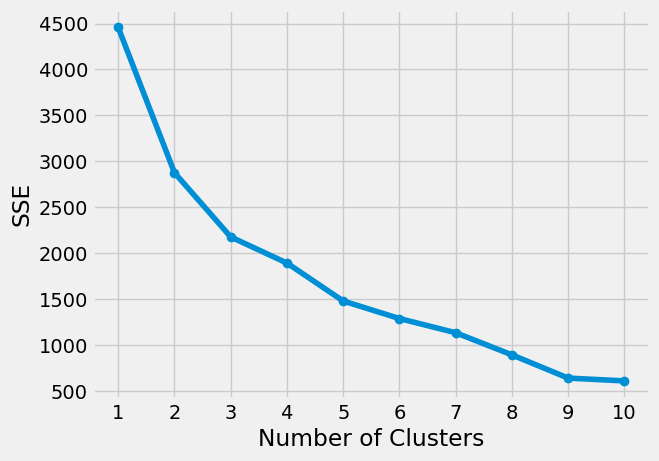

In [55]:
PCA_Quantity_10 = ['PC_1','PC_2','PC_3','PC_4','PC_5','PC_6']

kmeans_kwargs = {
    "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
}

SSE_10 = []

# Run K-means for each K and store the inertia value
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data_quantity_10[PCA_Quantity_10])
    SSE_10.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), SSE_10, marker='o')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [56]:
Kl_10 = KneeLocator(
    range(1, 11), SSE_10, curve="convex", direction="decreasing"
)
K_value_10 = Kl_10.elbow
print(f'El valor óptimo de clusters basado en la data que tenemos es {K_value_10}')

El valor óptimo de clusters basado en la data que tenemos es 3


#### K-Means Clúster

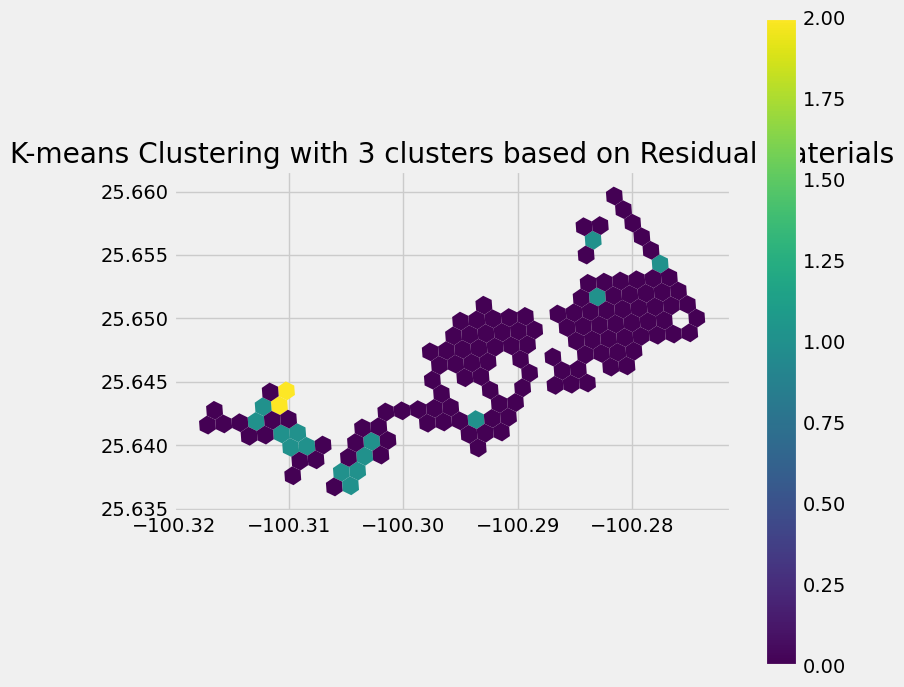

In [57]:
K_10 =  K_value_10


Kmeans_10 = KMeans(n_clusters=K_10, **kmeans_kwargs)
data_quantity_10['cluster'] = Kmeans_10.fit_predict(data_quantity_10[PCA_Quantity_10])

# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))
data_quantity_10.plot(column='cluster', cmap='viridis', legend=True, ax=ax)
plt.title(f'K-means Clustering with {K_10} clusters based on Residual Materials')
plt.show()

In [58]:
data_quantity_10['cluster'].unique()

array([1, 0, 2], dtype=int32)

In [59]:
data_quantity_10.head(2)

,hex_id,res,geometry,aluminio_quantity,baterias_quantity,carton_quantity,cenizas_quantity,ceramica_quantity,electronica_quantity,escombros_quantity,...,epi_quantity,total_quantity,most_common_quantity,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,cluster
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",2.795958,-0.079399,4.886608,-0.104500,4.433064,1.291156,0.654209,...,0.899029,2669.0,Plastico_quantity,11.514092,-4.262148,-0.300548,2.866509,-2.974002,-0.507405,1
1,8a48a202978ffff,10,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",3.922789,-0.079399,1.381922,1.620132,0.262632,3.511210,1.162324,...,-0.150047,2473.0,Plastico_quantity,9.070882,-1.336028,2.954100,3.774568,-0.063748,-0.267095,1


#### 3 Materiales Más Importantes por hexágono

In [60]:
imp_var = ['aluminio_quantity', 'baterias_quantity',
       'carton_quantity', 'cenizas_quantity', 'ceramica_quantity',
       'electronica_quantity', 'escombros_quantity', 'goma_quantity',
       'llantas_quantity', 'madera_quantity', 'metal_quantity',
       'organico_quantity', 'otros_quantity', 'papel_quantity',
       'pesca_quantity', 'plastico_quantity', 'salud e higiene_quantity',
       'tabaco_quantity', 'tela_quantity', 'unicel_quantity',
       'vidrio_quantity', 'epi_quantity']

#lista_hex = data_quantity['hex_id'].tolist()
lista_top3_maximos_10 = []
lista_top3_materiales_10 = []
cantidad_filas = data_quantity_10.shape[0]

for i in range(cantidad_filas):
    #hex_id = lista_hex[i]
    fila_seleccionada_10 = data_quantity_10.iloc[i, 3:-8]
    
    # Sort the residuals and get the top 3 values and corresponding materials
    sorted_residuos_10 = sorted(zip(fila_seleccionada_10, imp_var), reverse=True)
    top3_maximos_10 = sorted_residuos_10[:3]
    
    # Separate the top 3 values and materials into separate lists
    top3_maximos_valores_10, top3_maximos_materiales_10 = zip(*top3_maximos_10)
    
    lista_top3_maximos_10.append(top3_maximos_valores_10)
    lista_top3_materiales_10.append(top3_maximos_materiales_10)
    
    # Print the results if needed
    #print(f'Top 3 residuals of hexagon {hex_id} ({i}): {top3_maximos}')

# Add the lists to the DataFrame
data_quantity_10['top3_maximos'] = lista_top3_maximos_10
data_quantity_10['top3_materiales'] = lista_top3_materiales_10
print(data_quantity_10.shape)
data_quantity_10.head()

(141, 36)


,hex_id,res,geometry,aluminio_quantity,baterias_quantity,carton_quantity,cenizas_quantity,ceramica_quantity,electronica_quantity,escombros_quantity,...,most_common_quantity,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,cluster,top3_maximos,top3_materiales
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",2.795958,-0.079399,4.886608,-0.104500,4.433064,1.291156,0.654209,...,Plastico_quantity,11.514092,-4.262148,-0.300548,2.866509,-2.974002,-0.507405,1,"(9.528772007725172, 5.293624733964433, 4.88660...","(unicel_quantity, metal_quantity, carton_quant..."
1,8a48a202978ffff,10,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",3.922789,-0.079399,1.381922,1.620132,0.262632,3.511210,1.162324,...,Plastico_quantity,9.070882,-1.336028,2.954100,3.774568,-0.063748,-0.267095,1,"(8.725998586367945, 4.911506743972354, 3.92278...","(unicel_quantity, plastico_quantity, aluminio_..."
2,8a48a202baaffff,10,"POLYGON ((-100.29357 25.64128, -100.29289 25.6...",-0.208927,-0.079399,3.496819,-0.104500,-0.181031,-0.188879,4.617505,...,Plastico_quantity,7.722193,-3.623274,-3.567763,10.413353,10.534888,3.605940,1,"(15.736280380908669, 6.85340288665458, 5.79656...","(tela_quantity, plastico_quantity, papel_quant..."
3,8a48a202ba1ffff,10,"POLYGON ((-100.29499 25.64119, -100.29431 25.6...",0.104082,-0.079399,-0.330138,-0.104500,-0.033143,-0.188879,3.326046,...,Plastico_quantity,1.876579,-0.264643,-0.449665,1.307838,1.729515,0.292310,0,"(3.3260463422179303, 2.818347112281196, 2.7138...","(escombros_quantity, plastico_quantity, papel_..."
4,8a48a202ba0ffff,10,"POLYGON ((-100.29641 25.64109, -100.29573 25.6...",-0.119496,-0.079399,-0.258202,-0.104500,-0.117650,-0.188879,3.347218,...,Plastico_quantity,1.130427,-0.279235,-0.214249,0.910503,2.391586,-0.121943,0,"(3.3472177931363394, 2.731910832847521, 1.1333...","(escombros_quantity, plastico_quantity, papel_..."


# Mapa Interactivo

In [63]:
import folium
from folium import GeoJson
import matplotlib.cm as cm
from matplotlib.colors import to_hex

# Create the main map
m = folium.Map(location=[data_quantity_10['geometry'].centroid.y.mean(), data_quantity_10['geometry'].centroid.x.mean()], zoom_start=14.45)

# Quantity Map 1
unique_materials_11_qty = data_quantity_11['cluster'].unique()
color_map_11_qty = cm.get_cmap('Accent', len(unique_materials_11_qty))
color_mapping_11_qty = {material: to_hex(color_map_11_qty(i)) for i, material in enumerate(unique_materials_11_qty)}

def get_color_11_qty(feature):
    material_value = feature['properties']['cluster']
    if material_value == 0:
        return "#f44336"
    elif material_value == 1:
        return "#6aa84f"
    elif material_value == 2:
        return "#8e7cc3"
    elif material_value == 3:
        return "#f2ff00"
 

g_11_qty = folium.plugins.FeatureGroupSubGroup(m, "Quantity Res 11")
m.add_child(g_11_qty)

geojson_layer_11_qty = GeoJson(data_quantity_11, zoom_on_click=True,
                        style_function=lambda feature: {
                            'fillColor': get_color_11_qty(feature),
                            'color': 'black',
                            'weight': 1,
                            'fillOpacity': 0.6,
                        },
                        highlight_function=lambda x: {'weight': 3, 'color': 'black'},
                        tooltip=folium.GeoJsonTooltip(fields=['most_common_quantity','top3_materiales', 'cluster'], labels=True, sticky=True)
                       ).add_to(g_11_qty)

# Quantity Map 2
unique_materials_10_qty = data_quantity_10['cluster'].unique()
color_map_10_qty = cm.get_cmap('Accent', len(unique_materials_10_qty))
color_mapping_10_qty = {material: to_hex(color_map_10_qty(i)) for i, material in enumerate(unique_materials_10_qty)}

def get_color_10_qty(feature):
    material_value = feature['properties']['cluster']
    if material_value == 0:
        return "#ff0000"
    elif material_value == 1:
        return "#00ff04"
    elif material_value == 2:
        return "#0800ff"
    elif material_value == 3:
        return "#f2ff00"


g_10_qty = folium.plugins.FeatureGroupSubGroup(m, "Quantity Res 10")
m.add_child(g_10_qty)

geojson_layer_10_qty = GeoJson(data_quantity_10, zoom_on_click=True,
                        style_function=lambda feature: {
                            'fillColor': get_color_10_qty(feature),
                            'color': 'black',
                            'weight': 1,
                            'fillOpacity': 0.6,
                        },
                        highlight_function=lambda x: {'weight': 3, 'color': 'black'},
                        tooltip=folium.GeoJsonTooltip(fields=['most_common_quantity','top3_materiales', 'cluster'], labels=True, sticky=True)
                       ).add_to(g_10_qty)

# Material Map 1
unique_materials_11_res = data_material_11['cluster'].unique()
color_map_11_res = cm.get_cmap('Accent', len(unique_materials_11_res))
color_mapping_11_res = {material: to_hex(color_map_11_res(i)) for i, material in enumerate(unique_materials_11_res)}

def get_color_11_res(feature):
    material_value = feature['properties']['cluster']
    if material_value == 0:
        return "#ff0000"
    elif material_value == 1:
        return "#00ff04"
    elif material_value == 2:
        return "#0800ff"
    elif material_value == 3:
        return "#f2ff00"


g_11_res = folium.plugins.FeatureGroupSubGroup(m, "Points Res 11")
m.add_child(g_11_res)

geojson_layer_11_res = GeoJson(data_material_11, zoom_on_click=True,
                        style_function=lambda feature: {
                            'fillColor': get_color_11_res(feature),
                            'color': 'black',
                            'weight': 1,
                            'fillOpacity': 0.6,
                        },
                        highlight_function=lambda x: {'weight': 3, 'color': 'black'},
                        tooltip=folium.GeoJsonTooltip(fields=['most_common_point','top3_materiales', 'cluster'], labels=True, sticky=True)
                       ).add_to(g_11_res)

# Material Map 2
unique_materials_10_res = data_material_10['cluster'].unique()
color_map_10_res = cm.get_cmap('Accent', len(unique_materials_10_res))
color_mapping_10_res = {material: to_hex(color_map_10_res(i)) for i, material in enumerate(unique_materials_10_res)}

def get_color_10_res(feature):
    material_value = feature['properties']['cluster']
    if material_value == 0:
        return "#ff0000"
    elif material_value == 1:
        return "#00ff04"
    elif material_value == 2:
        return "#0800ff"
    elif material_value == 3:
        return "#f2ff00"



g_10_res = folium.plugins.FeatureGroupSubGroup(m, "Points Res 10")
m.add_child(g_10_res)

geojson_layer_10_res = GeoJson(data_material_10, zoom_on_click=True,
                        style_function=lambda feature: {
                            'fillColor': get_color_10_res(feature),
                            'color': 'black',
                            'weight': 1,
                            'fillOpacity': 0.6,
                        },
                        highlight_function=lambda x: {'weight': 3, 'color': 'black'},
                        tooltip=folium.GeoJsonTooltip(fields=['most_common_point','top3_materiales', 'cluster'], labels=True, sticky=True)
                       ).add_to(g_10_res)

# Add custom colormap legend
colormap_legend_html = """
    <div style="position: fixed; bottom: 10px; right: 10px; z-index: 1000; padding: 10px; background-color: rgba(255, 255, 255, 0.7); border-radius: 5px; box-shadow: 0 0 5px rgba(0, 0, 0, 0.2);">
        <p><strong>Número de Clúster</strong></p>
        <p><span style="color: #ff0000;">Rojo</span>: 0</p>
        <p><span style="color: #00ff04;">Verde</span>: 1</p>
        <p><span style="color: #0800ff;">Morado</span>: 2</p>
        <p><span style="color: #f2ff00;">Amarillo</span>: 3</p>
    </div>
"""

m.get_root().html.add_child(folium.Element(colormap_legend_html))

# Add layer control
folium.LayerControl(collapsed=False).add_to(m)

m.save("Prom_PCA_KMeans_Arroyo_vivo.html")

# Show the map
m


In [61]:
summary_f.to_file(f'../../data/external/temporal_fromjupyter/arroyo_vivo/residuosarroyo_hex.gpkg')

DriverError: sqlite3_open(../../data/external/temporal_fromjupyter/arroyo_vivo/residuosarroyo_hex.gpkg) failed: unable to open database file

In [ ]:
aup.gdf_to_db_slow(summary_f, 'arroyovivo_residuosjornada_hex','projects_research', if_exists='replace')